In [7]:
from typing import List
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from scipy.ndimage import gaussian_filter
from skimage.transform import rescale
import cv2

# make text larger
plt.rc('font', size=16)

# Generating Graphs From Gaussians
We create a plot of 4 gaussian clusters with 100 nodes each.

In [ ]:
def compute_k_way_estimate(normalised_L, indicator_vectors, K):
    k_way_possibilities = []
    assert indicator_vectors.shape[1] == K, 'Indicator vectors should have K columns'
    for i in range(K):
        indicator = indicator_vectors[:, i]
        val = indicator.T @ normalised_L @ indicator
        k_way_possibilities.append(val)
    return max(k_way_possibilities)

In [ ]:
np.random.seed(9)
X1 = np.random.multivariate_normal(mean = [0,0], cov = [[1,0.5],[0.5,1]], size = 100)
X2 = np.random.multivariate_normal(mean = [0,5], cov = [[1,-0.5],[-0.5,1]], size = 100)
X3 = np.random.multivariate_normal(mean = [8,0], cov = [[1.5,0],[0,1]], size = 100)
X4 = np.random.multivariate_normal(mean = [7,5], cov = [[1,0.2],[0.2,1]], size = 100)
X = np.concatenate((X1, X2, X3, X4))
# plot with each cluster in a different color
plt.scatter(X1[:,0], X1[:,1], color = 'r')
plt.scatter(X2[:,0], X2[:,1], color = 'b')
plt.scatter(X3[:,0], X3[:,1], color = 'g')
plt.scatter(X4[:,0], X4[:,1], color = 'y')

plt.xlabel('x')
plt.ylabel('y')
plt.title('4 Gaussian Clusters')
plt.savefig('Figures/4GaussianClusters.png')

In [ ]:
# construct a graph from the data points using a threshold
def construct_graph(X, threshold):
    N = X.shape[0]
    A = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i != j:
                dist = np.linalg.norm(X[i] - X[j])
                if dist < threshold:
                    A[i, j] = 1
    return A

A = construct_graph(X, 4)
plt.figure()
G = nx.from_numpy_array(A)
pos = X
# make edges thin and transparent. 
colormap = ['r'] * 100 + ['b'] * 100 + ['g'] * 100 + ['y'] * 100
nx.draw(G, pos = pos, node_size = 10, edge_color = 'grey', width = 0.2, node_color = colormap)
plt.title('Graph Constructed from 4 Gaussian Clusters \n Threshold = 4')
plt.savefig('Figures/4GaussianClustersGraphThreshold4.png', bbox_inches = 'tight')
plt.close()

In [ ]:
# compute the normalized laplacian

degrees = np.sum(A, axis = 1)
D_inv_sqrt = np.diag(1 / np.sqrt(degrees))
norm_L = np.eye(A.shape[0]) - D_inv_sqrt @ A @ D_inv_sqrt
eigvals, eigvecs = np.linalg.eigh(norm_L)
idx = np.argsort(eigvals)
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# plot first 10 eigenvalues
fig = plt.figure(figsize=(8, 3))
plt.grid(True)
plt.scatter(range(1,9), eigvals[:8])
plt.xlabel('Index')
plt.xlim(1, 8.6)
plt.ylabel('Eigenvalue')
plt.yticks(np.arange(0, 1.1, 0.2))
plt.yticks(np.arange(0, 1.1, 0.1), minor=True)
plt.title(r"First 8 Eigenvalues of $\mathcal{L}$")
# write value on each point in small text
for i in range(8):
    plt.text(i + 1, eigvals[i], f'{eigvals[i]:.2f}', fontsize=10)
plt.savefig('Figures/4GaussianClusters8Eigenvalues.png')

In [ ]:
indicator_vectors = np.zeros((eigvecs.shape[0], 4))
D_sqrt = np.diag(np.sqrt(degrees))
for i in range(4):
    indicator_vectors[100*i:100*(i+1), i] = 1
    indicator_vectors[:, i] = D_sqrt @ indicator_vectors[:, i]
    indicator_vectors[:, i] = indicator_vectors[:, i] / np.linalg.norm(indicator_vectors[:, i])

# project indicator vectors onto the eigenvectors
Q_K_by_K = (indicator_vectors.T @ eigvecs[:,:4])
combined_indicator_vectors = indicator_vectors @ Q_K_by_K

for i in range(4):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(combined_indicator_vectors[:, i])
    for j in range(i):
        combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:, i]) * combined_indicator_vectors[:, j]
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(combined_indicator_vectors[:, i])

In [ ]:
rayleigh_quotients = np.diag(combined_indicator_vectors.T @ norm_L @ combined_indicator_vectors)
# sort
sorted_rayleigh_quotients = np.sort(rayleigh_quotients)

In [ ]:
B_1 = (rayleigh_quotients[0]+rayleigh_quotients[1])/(eigvals[2])
B_2 = (rayleigh_quotients[2] + rayleigh_quotients[3] - 2*eigvals[2] + eigvals[4]*B_1)/(eigvals[4] - eigvals[2])

In [ ]:
print(f"Upper Bound from Recursive Structure Theorem: {B_1 + B_2}")
print(f"Lower Bound from General Structure Theorem: {np.sum(rayleigh_quotients)/eigvals[4]}")
print(f"Lower Bound from Structure Theorem: {4*compute_k_way_estimate(norm_L, indicator_vectors, 4)/eigvals[4]}")

# Clustering of AISTATS Text Image
In this section we construct a graph from the AISTATS text image and perform spectral clustering on the graph. We then compute and compare our bounds.

In [ ]:
im = cv2.imread('Data/AISTATS2025-TEXT.png')
plt.imshow(im)

In [ ]:
im = cv2.imread('Data/AISTATS2025-TEXT.png')
plt.imshow(im)
smoothed_im = gaussian_filter(im, sigma=1)
rescaled_smoothed_im = rescale(smoothed_im, 0.15, anti_aliasing=False)
rescaled_smoothed_im = rescaled_smoothed_im[:, :, 0]
plt.imshow(rescaled_smoothed_im[:,:])
# remove axes
plt.axis('off')
plt.savefig("Figures/AISTATS2025-TEXT-GAUSSIANFILTER.png")

In [ ]:
# Compute distance matrix
euc_distances_color = euclidean_distances(rescaled_smoothed_im.reshape(-1, 1))
euc_distances_color = euc_distances_color / euc_distances_color.max()
euc_distances_color_squared = euc_distances_color ** 2

euc_distances_distance = euclidean_distances(np.arange(rescaled_smoothed_im.size).reshape(-1, 1))
euc_distances_distance = euc_distances_distance / euc_distances_distance.max()
euc_distances_distance_squared = euc_distances_distance ** 2


def sigma_median(distances: np.ndarray) -> float:
    triu_distances = np.triu(distances, k=1)
    # choose not to include 0 distances in the calculation
    sigma = np.median(triu_distances[triu_distances > 0])
    return sigma


sigma_color = sigma_median(euc_distances_color)
sigma_distance = sigma_median(euc_distances_distance)
affinity_matrix = np.exp(-euc_distances_color_squared / (2 * sigma_color ** 2)) * np.exp(
    -euc_distances_distance_squared / (2 * sigma_distance ** 2))
# set diagonal to 0
np.fill_diagonal(affinity_matrix, 0)
# construct norm laplacian
degrees = np.sum(affinity_matrix, axis=1)
normalized_laplacian = np.eye(affinity_matrix.shape[0]) - np.diag(
    1 / np.sqrt(np.sum(affinity_matrix, axis=1))) @ affinity_matrix @ np.diag(
    1 / np.sqrt(np.sum(affinity_matrix, axis=1)))
eigenvalues, eigenvectors = np.linalg.eigh(normalized_laplacian)
idx = eigenvalues.argsort()
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]


In [ ]:
# apply spectral clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
labels = kmeans.fit_predict(eigenvectors[:, 0:3])

# Reshape the labels to the image shape
segmented_image = labels.reshape(rescaled_smoothed_im.shape)
plt.imshow(segmented_image)
plt.axis('off')
plt.savefig('Figures/AISTATS2025-TEXT-3CLUSTERS.png')

In [ ]:
# Compute indicator vectors
indicator_vectors = np.zeros((eigenvectors.shape[0], n_clusters))
for i in range(n_clusters):
    indicator_vectors[:, i] = (labels == i).astype(int)

degrees = np.sum(affinity_matrix, axis=1)

D_sqrt = np.diag(np.sqrt(degrees))

for i in range(n_clusters):
    indicator_vectors[:, i] = D_sqrt @ indicator_vectors[:, i]
    indicator_vectors[:, i] = indicator_vectors[:, i]
    indicator_vectors[:, i] = indicator_vectors[:, i] / np.linalg.norm(indicator_vectors[:, i])

# project indicator vectors onto the eigenvectors
beta_K_by_K = (indicator_vectors.T @ eigenvectors[:,:n_clusters])


combined_indicator_vectors = indicator_vectors @ beta_K_by_K
for i in range(n_clusters):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(
        combined_indicator_vectors[:, i])
    for j in range(i):
        combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] - (
                    combined_indicator_vectors[:, j].T @ combined_indicator_vectors[:,
                                                         i]) * combined_indicator_vectors[:, j]
    
for i in range(n_clusters):
    combined_indicator_vectors[:, i] = combined_indicator_vectors[:, i] / np.linalg.norm(combined_indicator_vectors[:, i])
    
# compute the rayleigh quotients
rayleigh_quotients = []
for i in range(n_clusters):
    indicator = combined_indicator_vectors[:, i]
    val = (indicator.T @ normalized_laplacian @ indicator) / (indicator.T @ indicator)
    rayleigh_quotients.append(val)

# sort the rayleigh quotients
sorted_rayleigh_quotients = np.sort(rayleigh_quotients)

In [ ]:
B_1 = rayleigh_quotients[0]/eigenvalues[1]
B_2 = ((rayleigh_quotients[2] + rayleigh_quotients[1]) - 2*eigenvalues[1] + eigenvalues[3]*B_1)/(eigenvalues[3] - eigenvalues[1])

In [ ]:
print(f"Upper Bound from Recursive Structure Theorem: {B_1 + B_2}")
print(f"Lower Bound from General Structure Theorem: {np.sum(rayleigh_quotients)/eigenvalues[3]}")
print(f"Lower Bound from Structure Theorem: {3*compute_k_way_estimate(normalized_laplacian, indicator_vectors, 3)/eigenvalues[3]}")

# Plots for Synthetic Digraphs

In [ ]:
def compute_volume(S: list, degrees: np.ndarray):
    return np.sum([degrees[i] for i in S])

#must use the adjacency matrix, not the hermitian adjacency matrix
def compute_weight_between_sets(S1:list, S2:list, A: np.ndarray):
    return np.sum([A[i,j] for i in S1 for j in S2])

def Upsilon(partition: List[List[int]], A: np.ndarray, degrees: np.ndarray, C: List[tuple]):
    k = len(partition)
    volume = np.sum(degrees)
    weight_total = 0
    for i in range(k):
        for j in range(k):
             if (i,j) not in C:
                 weight = compute_weight_between_sets(partition[i], partition[j], A)
                 weight_total += weight
    return weight_total/volume


def compute_theta(partition: List[List[int]], A: np.ndarray, degrees: np.ndarray, C: List[tuple]):
    k = len(partition)
    N = len(A)
    weight_total = 0
    for i in range(k):
        for j in range(k):
            if (i, j) in C:
                vol_i = compute_volume(partition[i], degrees)
                vol_j = compute_volume(partition[j], degrees)
                weight = compute_weight_between_sets(partition[i], partition[j], A) / (vol_i + vol_j)
                weight_total += weight
    return weight_total


def compute_new_bound(eigvals, ups):
    b1 = (4 * ups - eigvals[0]) / (eigvals[1] - eigvals[0])
    b2 = (4 * ups) / (eigvals[1])
    return np.min([b1, b2])


def compute_ls_bounds(eigvals, theta, k):
    gamma = eigvals[1] / (1 - (4 / k) * theta)
    bound_1 = 1 / gamma
    bound_2 = 1 / (gamma - 1)
    return bound_1, bound_2

In [ ]:
def get_hermitian_adjacency_matrix(N, edges, root_of_unity: int = 4) -> np.array:
    adjacency_matrix = np.zeros((N, N), dtype=np.complex128)
    w_k = np.exp(2 * np.pi * 1j / root_of_unity)
    w_k_conj = np.conj(w_k)
    for edge in edges:
        adjacency_matrix[edge] = w_k
        adjacency_matrix[(edge[::-1])] = w_k_conj
    return adjacency_matrix

def get_adjacency_matrix(N, edges) -> np.array:
    adjacency_matrix = np.zeros((N, N))
    for edge in edges:
        adjacency_matrix[edge] = 1
    return adjacency_matrix

## A Cycle with 4 clusters, adding noise

In [ ]:
# construct directed graph with 10 cycle
n = [0, 100, 200, 300, 400]
N = n[-1]
k = 4

bounds = {}

partition = []
for i in range(k):
    partition.append([j for j in range(n[i], n[i + 1])])
### FOR CYCLE
C = [(i, (i + 1) % k) for i in range(k)]
C_path = [(i, i + 1) for i in range(k - 1)]

F = np.array([[0.5, 1.0, 0.5, 0.0],
              [0.0, 0.5, 1.0, 0.5],
              [0.5, 0.0, 0.5, 1.0],
              [1.0, 0.5, 0.0, 0.5]])

def generate_P_cycle(eps=0.01):
    P = [[eps, 1.0, eps, 1.0],
         [1.0, eps, 1.0, eps],
         [eps, 1.0, eps, 1.0],
         [1.0, eps, 1.0, eps]]
    return np.array(P)


for eps in np.arange(0, 0.2, 0.01):
    P = generate_P_cycle(eps)
    edges = []

    for i in range(k):
        for j in range(k):
            if i == j:
                prob_existing_edge = P[i, j]
                for index, u in enumerate(partition[i]):
                    for v in partition[i][index + 1:]:
                        if u == v:
                            continue
                        if np.random.rand() <= prob_existing_edge:
                            if np.random.rand() <= F[i, j]:
                                edges.append((u, v))
                            else:
                                edges.append((v, u))
            else:
                prob_existing_edge = P[i, j]
                for u in partition[i]:
                    for v in partition[j]:
                        if np.random.rand() <= prob_existing_edge:
                            if np.random.rand() <= F[i, j]:
                                edges.append((u, v))
                            else:
                                edges.append((v, u))


    A = get_hermitian_adjacency_matrix(N = N, edges = edges, root_of_unity=k)
    degrees = np.sum(np.abs(A), axis=1)
    D = np.diag(degrees)
    D_sqrt = np.diag(np.sqrt(degrees))
    D_inv_sqrt = np.diag(1 / np.sqrt(degrees))
    norm_L = np.eye(int(N)) - D_inv_sqrt @ A @ D_inv_sqrt
    
    # construct indicator vector
    ind_vector = np.zeros((N,), dtype = np.complex128)
    for i in range(k):
        ind_vector[n[i]:n[i+1]] = np.exp(-1j * 2 * np.pi * i / k)
    ind_vector = D_sqrt @ ind_vector
    ind_vector = ind_vector / np.linalg.norm(ind_vector)
    
    # compute rayleigh quotient of indicator vector
    chi_rayleigh_quotient = np.real((np.conj(ind_vector).T @ norm_L @ ind_vector) / (np.conj(ind_vector).T @ ind_vector))
    

    #Now computing using Laenen & Sun's choice of roots of unity
    k_ls = int(np.ceil(2 * np.pi * k))
    A_ls = get_hermitian_adjacency_matrix(N = N, edges = edges, root_of_unity=k_ls)
    D_ls = np.sum(np.abs(A_ls), axis=1)
    D_inv_sqrt_ls = np.diag(1 / np.sqrt(D_ls))
    norm_L_ls = np.eye(int(N)) - D_inv_sqrt_ls @ A_ls @ D_inv_sqrt_ls

    eigvals, eigvecs = np.linalg.eigh(norm_L)
    idx = eigvals.argsort()
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    ls_eigvals, ls_eigvecs = np.linalg.eigh(norm_L_ls)
    # sort
    idx = ls_eigvals.argsort()
    ls_eigvals = ls_eigvals[idx]
    ls_eigvecs = ls_eigvecs[:, idx]
    A_standard = get_adjacency_matrix(N, edges)
    ups = Upsilon(partition, A_standard, degrees, C)
    theta = compute_theta(partition, A_standard, degrees, C_path)
    
    # computing true value
    true_val = np.linalg.norm(eigvecs[:,0] - (np.conj(ind_vector).T @ eigvecs[:,0]) * ind_vector)**2
    
    new_bound_rayleigh_quotient = min((chi_rayleigh_quotient - eigvals[0])/ (eigvals[1] - eigvals[0]), chi_rayleigh_quotient / eigvals[1])
    new_bound = compute_new_bound(eigvals, ups)
    ls_bound_1, ls_bound_2 = compute_ls_bounds(ls_eigvals, theta, k)

    bounds[eps] = {'true_val': true_val,
                   'new_bound': new_bound,
                   'new_bound_rayleigh_quotient':new_bound_rayleigh_quotient,
                   'ls_bound_1': ls_bound_1,
                   'ls_bound_2': ls_bound_2,
                   'Upsilon': ups,
                   'lambda_1': eigvals[0],
                   'lambda_2': eigvals[1],
                   'rayleigh quotient': chi_rayleigh_quotient}
bounds_df = pd.DataFrame(bounds).T
bounds_df.columns = [r'$\|f_1 - \alpha \chi\|^2$',
                     r'$\frac{4 \Psi - \lambda_1}{\lambda_2 - \lambda_1}$',
                      r'$\frac{\chi^* \mathcal{L} \chi - \lambda_1}{\lambda_2 - \lambda_1}$',
                     r'$\frac{1}{\eta_k}$',
                     r'$\frac{1}{\eta_4-1}$',
                     'ups',
                     'lambda_1',
                     'lambda_2',
                     'rayleigh quotient']

In [ ]:
bounds_df[[r'$\|f_1 - \alpha \chi\|^2$', r'$\frac{4 \Psi - \lambda_1}{\lambda_2 - \lambda_1}$', r'$\frac{\chi^* \mathcal{L} \chi - \lambda_1}{\lambda_2 - \lambda_1}$', r'$\frac{1}{\eta_4-1}$']][
    (bounds_df[r'$\frac{4 \Psi - \lambda_1}{\lambda_2 - \lambda_1}$'] <= 0.8) + (bounds_df[r'$\frac{1}{\eta_4-1}$'] <= 0.8)].iloc[1:,:].plot(
    title=r'Cyclic DSBM (k=4)', marker='o', linestyle='-', color=['purple','blue','green', 'red'],
    figsize=(10, 5), logy = True)
plt.xlabel(r'Noise $\epsilon$')
plt.ylabel(r'Error')
plt.grid(True)
# put legend outside the plot
plt.legend(fontsize='small', bbox_to_anchor=(1, 1))
plt.savefig('Figures/4_cluster_cycle_noise.png',bbox_inches='tight')

## Graph with 4 clusters in a path

In [ ]:
# construct directed graph with 10 cycle
n = [0, 100, 200, 300, 400]
N = n[-1]
k = 4

bounds = {}

partition = []
for i in range(k):
    partition.append([j for j in range(n[i], n[i + 1])])
### FOR CYCLE
C = [(i, (i + 1) % k) for i in range(k)]
C_path = [(i, i + 1) for i in range(k - 1)]

F = np.array([[0.5, 1.0, 0.5, 0.5],
              [0.0, 0.5, 1.0, 0.5],
              [0.5, 0.0, 0.5, 1.0],
              [0.5, 0.5, 0.0, 0.5]])

def generate_P_cycle(eps=0.01):
    P = [[eps, 1.0, eps, eps],
         [1.0, eps, 1.0, eps],
         [eps, 1.0, eps, 1.0],
         [eps, eps, 1.0, eps]]
    return np.array(P)


for eps in np.arange(0, 0.2, 0.01):
    P = generate_P_cycle(eps)
    edges = []

    for i in range(k):
        for j in range(k):
            if i == j:
                prob_existing_edge = P[i, j]
                for index, u in enumerate(partition[i]):
                    for v in partition[i][index + 1:]:
                        if u == v:
                            continue
                        if np.random.rand() <= prob_existing_edge:
                            if np.random.rand() <= F[i, j]:
                                edges.append((u, v))
                            else:
                                edges.append((v, u))
            else:
                prob_existing_edge = P[i, j]
                for u in partition[i]:
                    for v in partition[j]:
                        if np.random.rand() <= prob_existing_edge:
                            if np.random.rand() <= F[i, j]:
                                edges.append((u, v))
                            else:
                                edges.append((v, u))


    A = get_hermitian_adjacency_matrix(N = N, edges = edges, root_of_unity=k)
    degrees = np.sum(np.abs(A), axis=1)
    D = np.diag(degrees)
    D_sqrt = np.diag(np.sqrt(degrees))
    D_inv_sqrt = np.diag(1 / np.sqrt(degrees))
    norm_L = np.eye(int(N)) - D_inv_sqrt @ A @ D_inv_sqrt
    
    # construct indicator vector
    ind_vector = np.zeros((N,), dtype = np.complex128)
    for i in range(k):
        ind_vector[n[i]:n[i+1]] = np.exp(-1j * 2 * np.pi * i / k)
    ind_vector = D_sqrt @ ind_vector
    ind_vector = ind_vector / np.linalg.norm(ind_vector)
    
    # compute rayleigh quotient of indicator vector
    chi_rayleigh_quotient = np.real((np.conj(ind_vector).T @ norm_L @ ind_vector) / (np.conj(ind_vector).T @ ind_vector))
    

    #Now computing using Laenen & Sun's choice of roots of unity
    k_ls = int(np.ceil(2 * np.pi * k))
    A_ls = get_hermitian_adjacency_matrix(N = N, edges = edges, root_of_unity=k_ls)
    D_ls = np.sum(np.abs(A_ls), axis=1)
    D_inv_sqrt_ls = np.diag(1 / np.sqrt(D_ls))
    norm_L_ls = np.eye(int(N)) - D_inv_sqrt_ls @ A_ls @ D_inv_sqrt_ls

    eigvals, eigvecs = np.linalg.eigh(norm_L)
    idx = eigvals.argsort()
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    ls_eigvals, ls_eigvecs = np.linalg.eigh(norm_L_ls)
    # sort
    idx = ls_eigvals.argsort()
    ls_eigvals = ls_eigvals[idx]
    ls_eigvecs = ls_eigvecs[:, idx]
    A_standard = get_adjacency_matrix(N, edges)
    ups = Upsilon(partition, A_standard, degrees, C)
    theta = compute_theta(partition, A_standard, degrees, C_path)
    
    # computing true value
    true_val = np.linalg.norm(eigvecs[:,0] - (np.conj(ind_vector).T @ eigvecs[:,0]) * ind_vector)**2
    
    new_bound_rayleigh_quotient = min((chi_rayleigh_quotient - eigvals[0])/ (eigvals[1] - eigvals[0]), chi_rayleigh_quotient / eigvals[1])
    new_bound = compute_new_bound(eigvals, ups)
    ls_bound_1, ls_bound_2 = compute_ls_bounds(ls_eigvals, theta, k)

    bounds[eps] = {'true_val': true_val,
                   'new_bound': new_bound,
                   'new_bound_rayleigh_quotient':new_bound_rayleigh_quotient,
                   'ls_bound_1': ls_bound_1,
                   'ls_bound_2': ls_bound_2,
                   'Upsilon': ups,
                   'lambda_1': eigvals[0],
                   'lambda_2': eigvals[1],
                   'rayleigh quotient': chi_rayleigh_quotient}
bounds_df = pd.DataFrame(bounds).T
bounds_df.columns = [r'$\|f_1 - \alpha \chi\|^2$',
                     r'$\frac{4 \Psi - \lambda_1}{\lambda_2 - \lambda_1}$',
                      r'$\frac{\chi^* \mathcal{L} \chi - \lambda_1}{\lambda_2 - \lambda_1}$',
                     r'$\frac{1}{\eta_k}$',
                     r'$\frac{1}{\eta_4-1}$',
                     'ups',
                     'lambda_1',
                     'lambda_2',
                     'rayleigh quotient']


In [ ]:
bounds_df[[r'$\|f_1 - \alpha \chi\|^2$', r'$\frac{4 \Psi - \lambda_1}{\lambda_2 - \lambda_1}$', r'$\frac{\chi^* \mathcal{L} \chi - \lambda_1}{\lambda_2 - \lambda_1}$', r'$\frac{1}{\eta_4-1}$']][
    (bounds_df[r'$\frac{4 \Psi - \lambda_1}{\lambda_2 - \lambda_1}$'] <= 0.8) + (bounds_df[r'$\frac{1}{\eta_4-1}$'] <= 0.8)].iloc[1:,:].plot(
    title=r'Path DSBM (k=4)', marker='o', linestyle='-', color=['purple','blue','green', 'red'],
    figsize=(10, 5), logy = True)
plt.xlabel(r'Noise $\epsilon$')
plt.ylabel(r'Error')
plt.grid(True)
# put legend outside the plot
plt.legend(fontsize='small', bbox_to_anchor=(1, 1))
plt.savefig('Figures/4_cluster_path_noise.png',bbox_inches='tight')

# YellowStone Graph

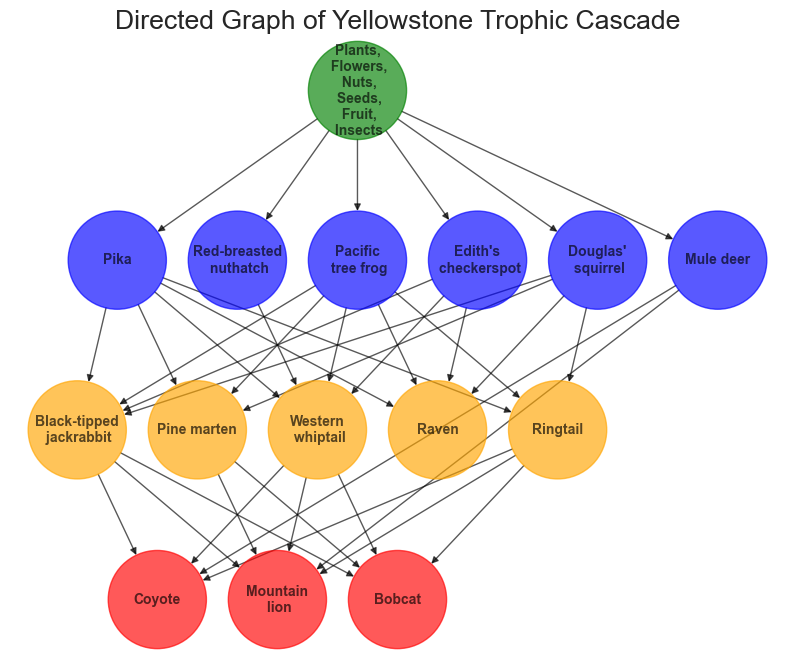

In [29]:
# Nodes and edges for the second image
nodes = [
    "Plants,\n Flowers,\n Nuts,\n Seeds,\n Fruit,\n Insects", "Pika", "Red-breasted\n nuthatch",
    "Pacific\n tree frog", "Edith's\n checkerspot", "Douglas'\n squirrel", "Mule deer",
    "Black-tipped\n jackrabbit", "Pine marten", "Western\n whiptail", "Raven",
    "Ringtail", "Coyote", "Mountain\n lion", "Bobcat"
]

# Initialize the adjacency matrix with zeros
adj_matrix = np.zeros((len(nodes), len(nodes)), dtype=int)

# Map the nodes to matrix index
index_map = {species: i for i, species in enumerate(nodes)}

partition = {"Producers and Decomposer": ["Plants,\n Flowers,\n Nuts,\n Seeds,\n Fruit,\n Insects"],
             "Primary Consumers": ["Pika", "Red-breasted\n nuthatch", "Pacific\n tree frog", "Edith's\n checkerspot",
                                   "Douglas'\n squirrel", "Mule deer"],
             "Secondary Consumers": ["Black-tipped\n jackrabbit", "Pine marten", "Western\n whiptail", "Raven", "Ringtail"],
             "Tertiary Consumers": ["Coyote", "Mountain\n lion", "Bobcat"]}

partition_numbered = [[index_map[species] for species in community] for community in partition.values()]
# Manually add edges based on the image (directed edges where energy is transferred)
edges = [
    ("Plants,\n Flowers,\n Nuts,\n Seeds,\n Fruit,\n Insects", "Pika"),
    ("Plants,\n Flowers,\n Nuts,\n Seeds,\n Fruit,\n Insects", "Red-breasted\n nuthatch"),
    ("Plants,\n Flowers,\n Nuts,\n Seeds,\n Fruit,\n Insects", "Pacific\n tree frog"),
    ("Plants,\n Flowers,\n Nuts,\n Seeds,\n Fruit,\n Insects", "Edith's\n checkerspot"),
    ("Plants,\n Flowers,\n Nuts,\n Seeds,\n Fruit,\n Insects", "Douglas'\n squirrel"),
    ("Plants,\n Flowers,\n Nuts,\n Seeds,\n Fruit,\n Insects", "Mule deer"),

    ("Pika", "Ringtail"),
    ("Pika", "Western\n whiptail"),
    ("Pika", "Raven"),
    ("Pika", "Black-tipped\n jackrabbit"),
    ("Pika", "Pine marten"),

    ("Red-breasted\n nuthatch", "Western\n whiptail"),

    ("Pacific\n tree frog", "Ringtail"),
    ("Pacific\n tree frog", "Western\n whiptail"),
    ("Pacific\n tree frog", "Raven"),
    ("Pacific\n tree frog", "Black-tipped\n jackrabbit"),
    ("Pacific\n tree frog", "Pine marten"),

    ("Edith's\n checkerspot", "Western\n whiptail"),
    ("Edith's\n checkerspot", "Raven"),
    ("Edith's\n checkerspot", "Black-tipped\n jackrabbit"),

    ("Douglas'\n squirrel", "Ringtail"),
    ("Douglas'\n squirrel", "Raven"),
    ("Douglas'\n squirrel", "Black-tipped\n jackrabbit"),
    ("Douglas'\n squirrel", "Pine marten"),

    ("Mule deer", "Mountain\n lion"),
    ("Mule deer", "Coyote"),

    ("Ringtail", "Coyote"),
    ("Ringtail", "Mountain\n lion"),
    ("Ringtail", "Bobcat"),

    ("Western\n whiptail", "Mountain\n lion"),
    ("Western\n whiptail", "Bobcat"),
    ("Western\n whiptail", "Coyote"),

    ("Black-tipped\n jackrabbit", "Mountain\n lion"),
    ("Black-tipped\n jackrabbit", "Coyote"),
    ("Black-tipped\n jackrabbit", "Bobcat"),

    ("Pine marten", "Mountain\n lion"),
    ("Pine marten", "Bobcat")
]

# Now we can fill the adjacency matrix again based on these edges
for source, target in edges:
    adj_matrix[index_map[source], index_map[target]] = 1

# Create a DataFrame for better visualization
adj_matrix_df = pd.DataFrame(adj_matrix, index=nodes, columns=nodes)
G = nx.DiGraph()

# Add edges to the graph from the previous trophic relationships
G.add_edges_from(edges)

pos = {
    "Plants,\n Flowers,\n Nuts,\n Seeds,\n Fruit,\n Insects": (0, 6),

    "Pika": (-6, 4), "Red-breasted\n nuthatch": (-3, 4), "Pacific\n tree frog": (0, 4), 
    "Edith's\n checkerspot": (3, 4), "Douglas'\n squirrel": (6, 4), "Mule deer": (9, 4),

    "Black-tipped\n jackrabbit": (-7, 2), "Pine marten": (-4, 2), 
    "Western\n whiptail": (-1, 2), "Raven": (2, 2), "Ringtail": (5, 2),

    "Coyote": (-5, 0), "Mountain\n lion": (-2, 0), "Bobcat": (1, 0)
}


# Color mapping for different communities
color_map = {
    "Producers and Decomposer": "green",
    "Primary Consumers": "blue",
    "Secondary Consumers": "orange",
    "Tertiary Consumers": "red"
}

# Assign colors based on community
node_colors = []
for node in G.nodes():
    for community, members in partition.items():
        if node in members:
            node_colors.append(color_map[community])

# Plot the graph using networkx
plt.figure(figsize=(10, 8))
nx.draw_networkx(G, pos, with_labels=True, node_size=5000, node_color=node_colors,
                 font_size=10, font_color='black', font_weight='bold', edge_color='black', arrows=True, alpha=0.65)

# Display the plot
plt.title('Directed Graph of Yellowstone Trophic Cascade')
plt.axis('off')

plt.savefig('Figures/YellowstoneTrophicCascade2.png', bbox_inches='tight')
plt.show()



In [ ]:
# compute hermitian adjacency matrix
k = 4
k_ls = int(np.ceil(2 * np.pi * k))
A = adj_matrix * np.exp(1j * 2 * np.pi / 4) + adj_matrix.T * np.exp(-1j * 2 * np.pi / 4)
A_ls = adj_matrix * np.exp(1j * 2 * np.pi / k_ls) + adj_matrix.T * np.exp(-1j * 2 * np.pi / k_ls)
# compute degree matrix
degrees = np.sum(np.abs(A), axis=1)
D = np.diag(degrees)
D_sqrt = np.diag(np.sqrt(degrees))
D_inv_sqrt = np.diag(1 / np.sqrt(degrees))
norm_L = np.eye(len(nodes)) - D_inv_sqrt @ A @ D_inv_sqrt

#Compute indicator vector
ind_vector = np.zeros((len(nodes),), dtype = np.complex128)
for i in range(k):
    for node in partition[list(partition.keys())[i]]:
        ind_vector[index_map[node]] = np.exp(-1j * 2 * np.pi * i / k)
ind_vector = D_sqrt @ ind_vector
ind_vector = ind_vector / np.linalg.norm(ind_vector)

rayleigh_quotient = np.real((np.conj(ind_vector).T @ norm_L @ ind_vector) / (np.conj(ind_vector).T @ ind_vector))

#Now computing using Laenen & Sun's choice of roots of unity
D_ls = np.sum(np.abs(A_ls), axis=1)
D_inv_sqrt_ls = np.diag(1 / np.sqrt(D_ls))
norm_L_ls = np.eye(len(nodes)) - D_inv_sqrt_ls @ A_ls @ D_inv_sqrt_ls
evals, evecs = np.linalg.eigh(norm_L)
evals_ls, evecs_ls = np.linalg.eigh(norm_L_ls)
# plot first evec

C = [(0, 1), (1, 2), (2, 3), (3, 0)]

In [ ]:
plt.figure(figsize=(10, 10))

plt.plot(evecs[:, 0].real, evecs[:, 0].imag, '+', label='standard', alpha=0.5)
# add labels
for i, txt in enumerate(nodes):
    plt.annotate(txt, (evecs[i, 0].real, evecs[i, 0].imag))

# colour by community
for i, community in enumerate(partition_numbered):
    plt.plot(evecs[community, 0].real, evecs[community, 0].imag, 'o', label=f'community {i}', alpha=0.5)

In [ ]:
theta = compute_theta(partition_numbered, adj_matrix, degrees, [(i, i + 1) for i in range(4)])
ls_1, ls_2 = compute_ls_bounds(evals_ls, theta, k)
print("Theta is ", theta)
print("1/eta_k is ", ls_1)
print("1/(eta_k-1) is ", ls_2)

In [ ]:
upsilon = Upsilon(partition_numbered, adj_matrix, degrees, C)
new_bound = compute_new_bound(evals, upsilon)
new_bound_with_rayleigh_quotient = (rayleigh_quotient - evals[0])/(evals[1] - evals[0])
print("Rayleigh Quotient is ", rayleigh_quotient)
print("Upsilon is ", upsilon)
print("New bound is ",new_bound)
print("New bound with rayleigh quotient is ", new_bound_with_rayleigh_quotient)

# Covid Infection Graph

In [8]:
patient_info_df = pd.read_csv("Data/PatientInfo.csv")
patient_info_df.head()
edges_df = patient_info_df[["infected_by", "patient_id"]].dropna(subset=["infected_by"])
edges_df.columns = ["source", "target"]
edges_df = edges_df.astype(str)
# create adjacency matrix
index = list(set(edges_df["source"].values) | set(edges_df["target"].values))
index.sort()
adjacency_matrix = np.zeros((len(index), len(index)))
for i, row in edges_df.iterrows():
    source = row["source"]
    target = row["target"]
    source_index = index.index(source)
    target_index = index.index(target)
    adjacency_matrix[source_index, target_index] = 1
adjacency_matrix_df = pd.DataFrame(adjacency_matrix, index=index, columns=index)


In [9]:

def largest_connected_component_adjacency(df):
    # Convert the DataFrame to a NumPy array
    adj_matrix = df

    # Create a directed graph from the adjacency matrix
    G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)

    # Find the largest strongly connected component
    largest_wcc = max(nx.weakly_connected_components(G), key=len)

    # Create a subgraph from the largest SCC
    largest_wcc_subgraph = G.subgraph(largest_wcc)

    # Get the adjacency matrix of the largest SCC subgraph
    largest_wcc_adj_matrix = nx.to_numpy_array(largest_wcc_subgraph, nodelist=sorted(largest_wcc))

    # Create a new DataFrame for the adjacency matrix of the largest SCC
    largest_wcc_df = pd.DataFrame(largest_wcc_adj_matrix,
                                  index=sorted(largest_wcc),
                                  columns=sorted(largest_wcc))

    return largest_wcc_df

C:\Users\georg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


NameError: name 'compute_theta' is not defined

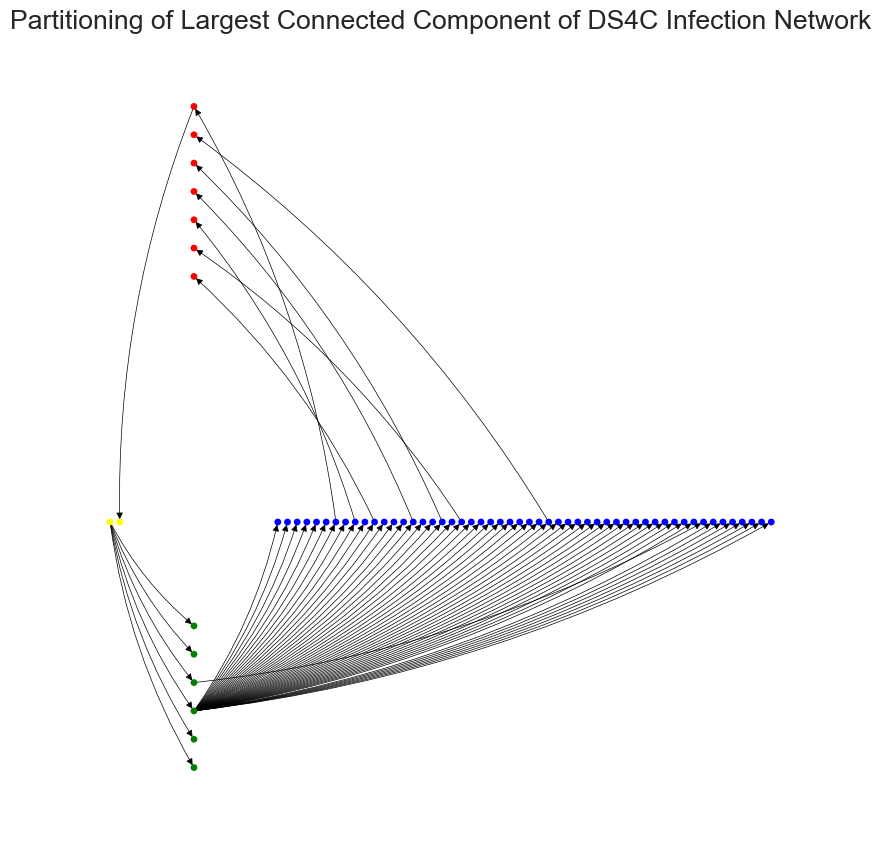

In [11]:
largest_wcc_df = largest_connected_component_adjacency(adjacency_matrix_df)
# draw graph
G = nx.from_pandas_adjacency(largest_wcc_df, create_using=nx.DiGraph)

k = 4
herm_A = np.exp(1j * 2 * np.pi / k) * largest_wcc_df.values + np.exp(-1j * 2 * np.pi / k) * largest_wcc_df.values.T
degrees = np.sum(np.abs(herm_A), axis=1)
D_inv_sqrt = np.diag(1 / np.sqrt(degrees))
norm_L = np.eye(len(herm_A)) - D_inv_sqrt @ herm_A @ D_inv_sqrt

k_ls = int(np.ceil(2 * np.pi * k))
herm_A_ls = np.exp(1j * 2 * np.pi / k_ls) * largest_wcc_df.values + np.exp(
    -1j * 2 * np.pi / k_ls) * largest_wcc_df.values.T
degrees_ls = np.sum(np.abs(herm_A_ls), axis=1)
D_inv_sqrt_ls = np.diag(1 / np.sqrt(degrees_ls))
norm_L_ls = np.eye(len(herm_A_ls)) - D_inv_sqrt_ls @ herm_A_ls @ D_inv_sqrt_ls

# Compute Eigenvectors and Eigenvalues
e_vals, e_vecs = np.linalg.eigh(norm_L)
e_vals_ls, e_vecs_ls = np.linalg.eigh(norm_L_ls)


datapoints = np.column_stack((D_inv_sqrt @ e_vecs[:, 0].real, D_inv_sqrt @ e_vecs[:, 0].imag))
kmeans = KMeans(n_clusters=4, random_state=0).fit(datapoints)
partition_numbered = [np.where(kmeans.labels_ == i)[0] for i in range(4)]

color_map = []
for i, node in enumerate(largest_wcc_df.index):
    if i in partition_numbered[0]:
        color_map.append('blue')
    elif i in partition_numbered[1]:
        color_map.append('red')
    elif i in partition_numbered[2]:
        color_map.append('green')
    elif i in partition_numbered[3]:
        color_map.append('yellow')
    else:
        color_map.append('black')
G = nx.from_pandas_adjacency(largest_wcc_df, create_using=nx.DiGraph)
pos = {}
partition_sizes = [len(partition) for partition in partition_numbered]
scale = 60
for i, node_number in enumerate(largest_wcc_df.index):
    if i in partition_numbered[0]:
        index_in_partition = np.where(partition_numbered[0] == i)[0][0]
        pos[node_number] = (10 + scale * index_in_partition / partition_sizes[0], 0)
    elif i in partition_numbered[1]:
        index_in_partition = np.where(partition_numbered[1] == i)[0][0]
        pos[node_number] = (0, 10 + scale * index_in_partition / partition_sizes[0])
    elif i in partition_numbered[2]:
        index_in_partition = np.where(partition_numbered[2] == i)[0][0]
        pos[node_number] = (0, -10 + scale * index_in_partition / partition_sizes[0])
    elif i in partition_numbered[3]:
        index_in_partition = np.where(partition_numbered[3] == i)[0][0]
        pos[node_number] = (-10 + scale * index_in_partition / partition_sizes[0], 0)
    else:
        pos[node_number] = (0, 0)

plt.figure(figsize=(8, 8))
nx.draw(G, pos, node_color=color_map, with_labels=False, node_size=15, width=0.5, connectionstyle='arc3, rad = 0.1')
plt.title("Partitioning of Largest Connected Component of DS4C Infection Network")
plt.savefig('Figures/DS4CInfectionNetwork.png', bbox_inches='tight')
# compute weight between every pair of clusters

C = [(2, 0), (0, 1), (1, 3), (3, 2)]

theta = compute_theta(partition_numbered, largest_wcc_df.values, degrees, C)
compute_ls_bounds(e_vals_ls, theta, k)
eta_k = e_vals_ls[1] / (1 - (4 / k) * theta)

print("Theta", theta)
print("eta_k", e_vals_ls[1] / (1 - (4 / k) * theta))
print("1/eta_k", 1/eta_k)
print("1/(eta_k-1)", 1/(eta_k - 1))

print("Upsilon", Upsilon(partition_numbered, largest_wcc_df.values, degrees, C))
print("New bound", compute_new_bound(e_vals, Upsilon(partition_numbered, largest_wcc_df.values, degrees, C)))
